In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

# gpu 문제로 코드가 안돌아가는 상황이 있어서 set_memory_growth 셋팅을 설정해준 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

model = load_model('model/299_drop/21-0.89714.h5')
model.summary()

1 Physical GPUs, 1 Logical GPUs
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________

(1, 299, 299, 3)


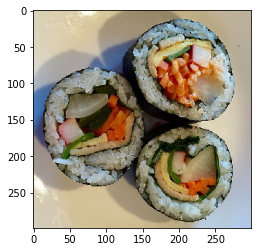

In [31]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = "test/gimbap.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])

In [32]:
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

Predict : 5


- '가지볶음': 0,
- '감자전': 1,
- '계란국': 2,
- '계란말이': 3,
- '계란찜': 4,
- '김밥': 5,
- '김치볶음밥': 6,
- '김치전': 7,
- '김치찌개': 8,
- '깍두기': 9,
- '닭갈비': 10,
- '도토리묵': 11,
- '된장찌개': 12,
- '땅콩조림': 13,
- '떡볶이': 14,
- '메추리알장조림': 15,
- '미역국': 16,
- '배추김치': 17,
- '불고기': 18,
- '비빔밥': 19,
- '삼계탕': 20,
- '소세지볶음': 21,
- '시금치나물': 22,
- '열무김치': 23,
- '유부초밥': 24,
- '육개장': 25,
- '잔치국수': 26,
- '잡채': 27,
- '제육볶음': 28,
- '칼국수': 29,
- '콩국수': 30,
- '콩나물국': 31,
- '콩나물무침': 32,
- '파전': 33,
- '호박죽': 34

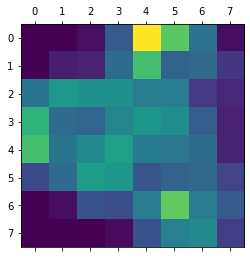

In [33]:
pred_output = model.output[:, 5]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

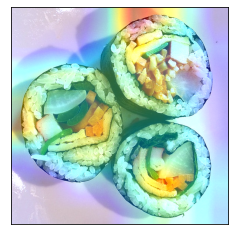

In [34]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)

plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 14


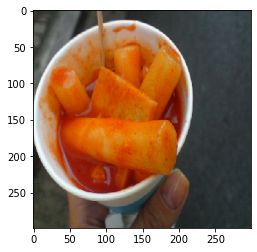

<Figure size 432x288 with 0 Axes>

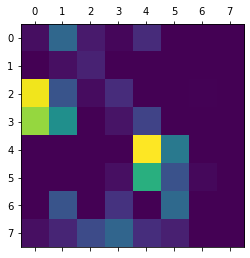

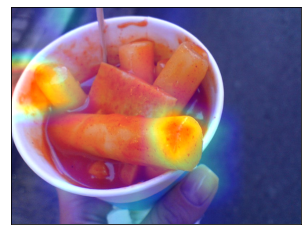

In [35]:
img_path = "test/tteok.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 0


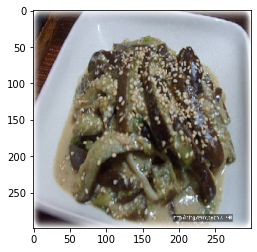

<Figure size 432x288 with 0 Axes>

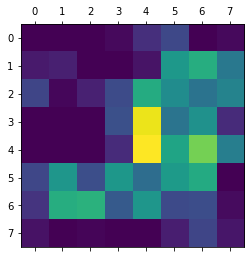

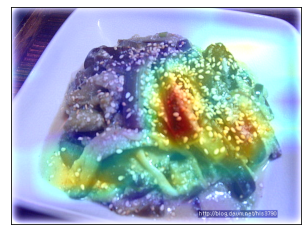

In [36]:
img_path = "test/Img_040_0004.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 34


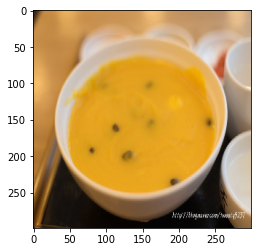

<Figure size 432x288 with 0 Axes>

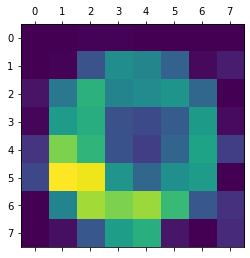

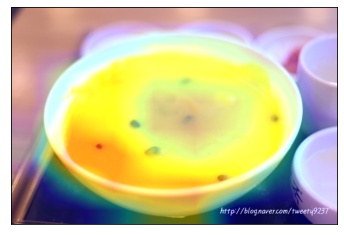

In [37]:
img_path = "test/hobak.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 34


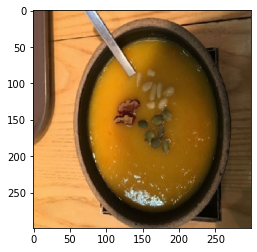

<Figure size 432x288 with 0 Axes>

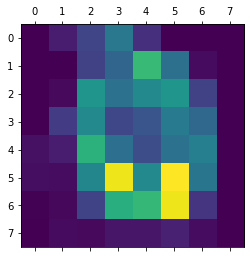

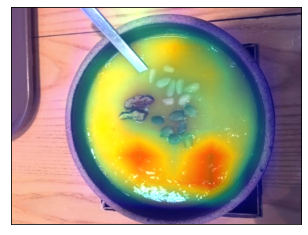

In [38]:
img_path = "test/hobak2.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 32


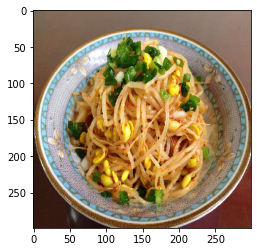

<Figure size 432x288 with 0 Axes>

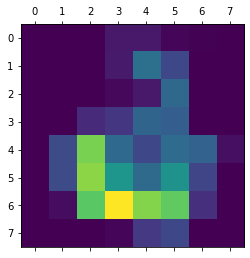

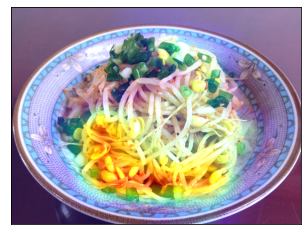

In [39]:
img_path = "test/kong.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 5


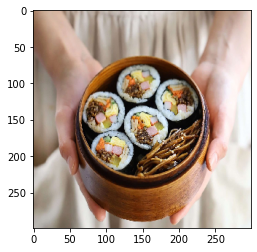

<Figure size 432x288 with 0 Axes>

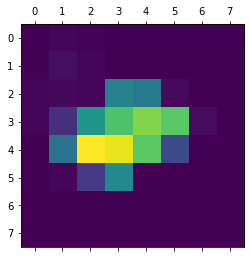

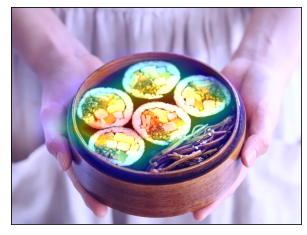

In [40]:
img_path = "test/gimbap2.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 5


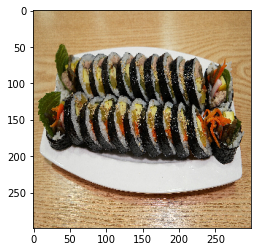

<Figure size 432x288 with 0 Axes>

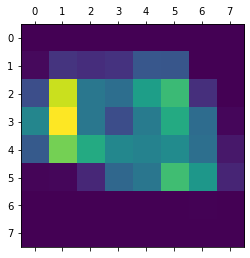

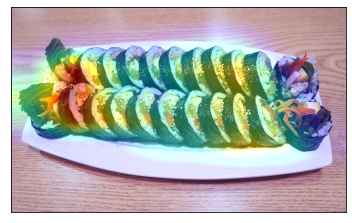

In [41]:
img_path = "test/gimbap3.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 6


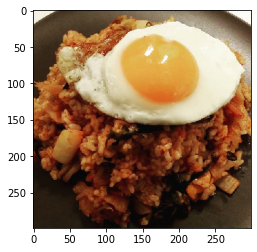

<Figure size 432x288 with 0 Axes>

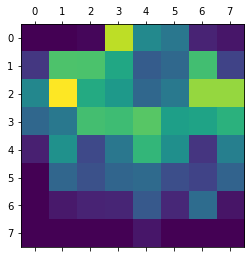

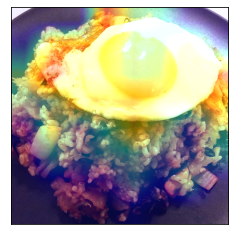

In [42]:
img_path = "test/kimchi.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 7


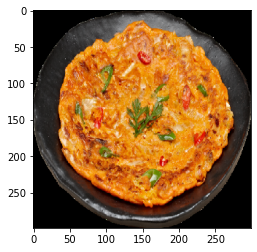

<Figure size 432x288 with 0 Axes>

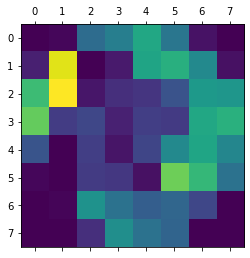

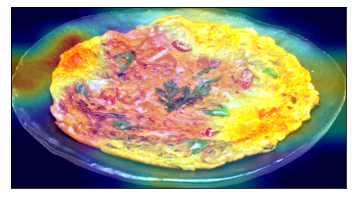

In [43]:
img_path = "test/kimchi2.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 34


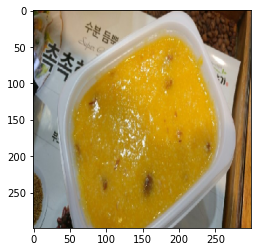

<Figure size 432x288 with 0 Axes>

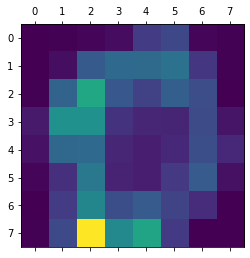

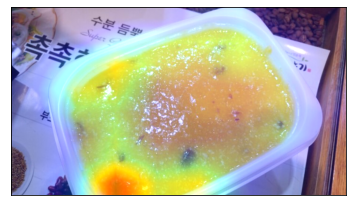

In [44]:
img_path = "test/hobak3.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 34


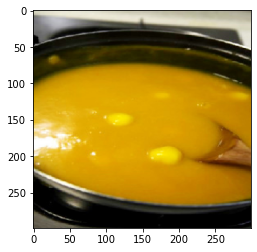

<Figure size 432x288 with 0 Axes>

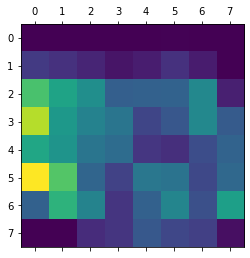

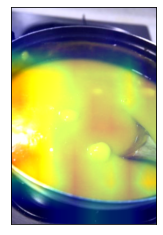

In [45]:
img_path = "test/hobak4.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])

(1, 299, 299, 3)
Predict : 28


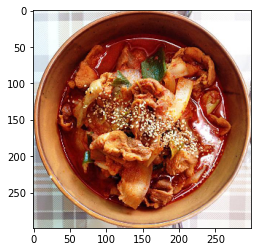

<Figure size 432x288 with 0 Axes>

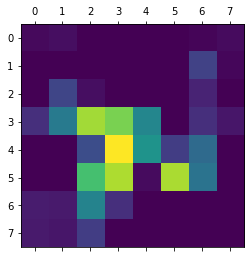

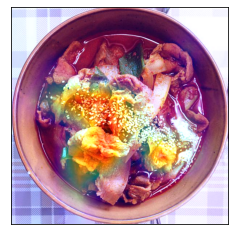

In [46]:
img_path = "test/jae.jpg"
img = image.load_img(img_path, target_size=(299,299))
img_tensor = image.img_to_array(img)

img_tensor /= 255.
img_tensor = img_tensor.reshape((1, 299, 299, 3))
print(img_tensor.shape)
plt.imshow(img_tensor[0])
preds = model.predict(img_tensor)
print(f'Predict : {np.argmax(preds)}')

pred_output = model.output[:, np.argmax(preds)]
last_conv_layer = model.get_layer('conv_7b_ac')
grads = K.gradients(pred_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(1536):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.figure()
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = np.clip((heatmap * 0.4 + img), 0, 255).astype(np.uint8)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(superimposed_img[:, :, ::-1])